- Imported libraries 
- Imported dataset 
- Created svm classifier

In [1]:
import pandas as pd
from sklearn import svm
import matplotlib.pyplot as plt
import numpy as np
import warnings
warnings.filterwarnings('ignore', category=UserWarning)


# Reading in the dataset
df=pd.read_csv('SVM_Dataset2.csv')

# SVM classifier with polynomial decision boundary
svm_classifier = svm.SVC(kernel='poly',C=10, degree=2, probability=True)
# svm_classifier = svm.SVC(kernel='rbf', gamma=0.1, C=100)

c:\Users\Compuworld\anaconda3\Lib\site-packages\pandas\core\arrays\masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


- Used KDTree for finding the closest point
- Rewrote the optimal_point function around KDTree

In [2]:
from scipy.spatial import KDTree

# Function to find closest point to contour from the non healthy point
def closest_point(point, contour):
    tree = KDTree(contour)
    closest_index = tree.query(point)[1]
    closest_point = contour[closest_index]
    return closest_point

def closest_border_point(border_points, contour): 
    # Build a KDTree for fast nearest neighbor search
    tree = KDTree(contour) 

    min_point, total_min = None, float('inf')

    for border_point in border_points: 
        # Find the distance and index of the closest contour point using KDTree
        dist, _ = tree.query(border_point)

        # Update the minimum point and distance if a closer point is found
        if dist < total_min: 
            total_min = dist 
            min_point = border_point 
    
    return min_point

# Displacement from A to B 

- We added ```move_from_A_to_B_with_x1_displacement``` to the ```optimal_point()``` function

In [3]:
def move_from_A_to_B_with_x1_displacement(A, B, deltas):
    """
    Move from point A to point B in n-dimensional space with a desired movement in the x1 dimension.
    
    Parameters:
    - A: list or np.array, coordinates of the starting point A
    - B: list or np.array, coordinates of the target point B
    - delta_x1: float, the desired displacement in the x1 dimension
    
    Returns:
    - P: np.array, coordinates of the new point after moving delta_x1 along x1-axis
    """
    A = np.array(A)
    B = np.array(B)
    
    # Calculate direction vector from A to B
    D = B - A
    
    # Calculate the scaling factor t for the desired movement in x1
    t = deltas / D  # D[0] is the x1 component of the direction vector
    
    # Calculate the new point P based on t
    P = A + t * D

    print(t) 
    print(D)
    
    return P

# Example usage
A = [1, 2, 3]  # Starting point in 3D space
B = [4, 5, 6]  # Target point in 3D space
delta_x1 = 1.5  # Desired movement in x1 dimension

P = move_from_A_to_B_with_x1_displacement(A, B, delta_x1)
print("New point P with desired x1 movement:", P)

[0.5 0.5 0.5]
[3 3 3]
New point P with desired x1 movement: [2.5 3.5 4.5]


In [23]:
from scipy.interpolate import interp1d

# Generates the decision boundary in the case of binary classification
def boundary_generator(xx1, xx2, model): 
    x_in = np.c_[xx1.ravel(), xx2.ravel()]
    y_pred = model.predict(x_in)
    y_pred = np.round(y_pred).reshape(xx1.shape)
    bound_data = []
    contour = plt.contour(xx1, xx2, y_pred, colors='red')
    for collection in contour.collections[:1]:
        for path in collection.get_paths():
            vertices = path.vertices
            x_coords = vertices[:, 0]
            y_coords = vertices[:, 1]
            bound_data.extend(zip(x_coords,y_coords))
    boundary_df = pd.DataFrame(data=bound_data, columns=['x1','x2'])
    print(boundary_df.shape)
    print(model.predict_proba(boundary_df))
    return boundary_df

# Gets boundary points
def boundary_points(xx1, xx2, model): 
    boundary_df = boundary_generator(xx1=xx1, xx2=xx2, model=model)
    boundary_df = boundary_df.drop_duplicates(subset='x1')

    bound_x, bound_y = boundary_df.iloc[:, 0], boundary_df.iloc[:, 1]
    return bound_x, bound_y 

def get_border_points(x, y, delta_x, delta_y, step=0.1):
    points = []        
    
    # Define the boundaries
    x_min, x_max = x - delta_x, x + delta_x
    y_min, y_max = y - delta_y, y + delta_y

    # Generate points along the four edges
    for i in np.arange(x_min, x_max + step, step):
        points.append((i, y_min))  # Bottom edge
        points.append((i, y_max))  # Top edge

    for j in np.arange(y_min, y_max + step, step):
        points.append((x_min, j))  # Left edge
        points.append((x_max, j))  # Right edge

    # Remove duplicates (corner points get added twice)
    points = list(set(points))
    
    return points


# Algorithm that determines the point that is closest to the decision boundary from a specified data point (undesired_coords) 
def  optimal_point(df, model, desired_class, undesired_coords, epsilon=0.01, change_px=None, change_py=None): 

    X1=df['x1']
    X2=df['x2']
    X_train=np.array(list(zip(X1,X2)))
    y_train=df['y'].values

    model.fit(X_train, y_train)

    bound_x, bound_y = None, None
    X = X_train
    x1_min, x1_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    x2_min, x2_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx1, xx2 = np.meshgrid(np.linspace(x1_min,x1_max, 2000),np.linspace(x2_min, x2_max, 2000))

    print(xx1.shape)

    bound_x, bound_y = boundary_points(xx1, xx2, model)

    N = 1000000
    lower_boundx, upper_boundx = np.min(bound_x), np.max(bound_x)
    f = interp1d(bound_x, bound_y, kind='cubic')
    X_pred = np.linspace(lower_boundx, upper_boundx, N)[:, np.newaxis]
    Y_pred = f(X_pred)
    lower_boundy, upper_boundy = np.min(Y_pred), np.max(Y_pred)

    contours = np.c_[X_pred, Y_pred]
    plt.plot(X_pred, Y_pred, color='black')

    undesired_datapt = np.array([undesired_coords[0], undesired_coords[1]])
    optimal_datapt = closest_point(undesired_datapt, contour=contours)

    if desired_class == 1: 
        D = optimal_datapt - undesired_datapt
        deltas = D * (1+epsilon)
        optimal_datapt = move_from_A_to_B_with_x1_displacement(undesired_datapt, optimal_datapt, deltas=deltas)
        plt.scatter(undesired_datapt[0], undesired_datapt[1], c = 'r')
        plt.text(undesired_datapt[0]+0.002, undesired_datapt[1]+0.002, 'NH')
        plt.scatter(optimal_datapt[0], optimal_datapt[1], c = 'b')
        plt.text(optimal_datapt[0]+0.002, optimal_datapt[1]+0.002, 'H')
        plt.plot([undesired_datapt[0], optimal_datapt[0]], [undesired_datapt[1],optimal_datapt[1]], linestyle='--')
        return optimal_datapt 
    elif desired_class == -1: 
        x,y = undesired_datapt[0], undesired_datapt[1]
        delta_x, delta_y = None, None 
        closest_boundedpt = None
        if (change_px is None and change_py is None) or (change_px == 'inf' and change_py == 'inf'): 
            raise TypeError("change_px and change_py are both None")
        elif change_px is None or change_px == 'inf': 
            delta_y = (change_py/100)*y
            print(delta_y)
            lowb_y, highb_y = max(y - (delta_y / 2), lower_boundy), min(y + (delta_y / 2), upper_boundy)
            plt.axhline(y=highb_y, color='b', linestyle='-', label='High Bound y')
            plt.axhline(y=lowb_y, color='b', linestyle='-', label='Low bound y')

            # Constrain the range of Y values
            indices = np.where((Y_pred >= lowb_y) & (Y_pred <= highb_y))
            Y_pred_bound = Y_pred[indices] 
            X_pred_bound = X_pred[indices] 
    
            bounded_contour_y = np.c_[X_pred_bound, Y_pred_bound]
            closest_contourpt = closest_point(point=undesired_datapt, contour=bounded_contour_y)
            closest_boundedpt = closest_contourpt
            print("UPPER AND LOWER BOUNDS ON Y: ", lowb_y, highb_y)
            print("CLOSEST BOUNDING POINT: ", closest_boundedpt)
        elif change_py is None or change_py == 'inf': 
            delta_x = (change_px/100)*x 
            lowb_x, highb_x = max(x - (delta_x/2), lower_boundx), min(x + (delta_x/2), upper_boundx)   
            plt.axvline(x=highb_x, color='b', linestyle='-', label='High Bound x')
            plt.axvline(x=lowb_x, color='b', linestyle='-', label='Low bound x')

            # Constrain the range of X values
            indices = np.where((X_pred >= lowb_x) & (X_pred <= highb_x))
            Y_pred_bound = Y_pred[indices] 
            X_pred_bound = X_pred[indices] 

            bounded_contour_x = np.c_[X_pred_bound, Y_pred_bound]
            closest_contourpt = closest_point(point=undesired_datapt, contour=bounded_contour_x)
            closest_boundedpt = closest_contourpt
            print("UPPER AND LOWER BOUNDS ON X: ", lowb_x, highb_x)
            print("CLOSEST BOUNDING POINT: ", closest_boundedpt)
        else: 
            delta_x, delta_y = (change_px/100)*x, (change_py/100)*y
            border_pts = get_border_points(x,y, delta_x, delta_y, step=0.05)
            deltas = np.array([delta_x, delta_y])
            x_values, y_values = zip(*border_pts)
            plt.scatter(x_values, y_values, marker='o')
            closest_borderpt = closest_border_point(border_pts, contour=contours)
            closest_boundedpt = closest_borderpt
        D = closest_boundedpt - undesired_datapt
        optimal_datapt = move_from_A_to_B_with_x1_displacement(undesired_datapt, closest_boundedpt, deltas=D)
        plt.scatter(undesired_datapt[0], undesired_datapt[1], c = 'r')
        plt.text(undesired_datapt[0]+0.002, undesired_datapt[1]+0.002, 'NH')
        plt.scatter(optimal_datapt[0], optimal_datapt[1], c = 'r')
        plt.text(optimal_datapt[0]+0.002, optimal_datapt[1]+0.002, 'NH')
        plt.plot([undesired_datapt[0], optimal_datapt[0]], [undesired_datapt[1],optimal_datapt[1]], linestyle='--')
        return optimal_datapt

(2000, 2000)
(3327, 2)
[[0.34568907 0.65431093]
 [0.34600087 0.65399913]
 [0.34631234 0.65368766]
 ...
 [0.34643206 0.65356794]
 [0.34539502 0.65460498]
 [0.34539502 0.65460498]]
[1.07 1.07]
[-0.27051579 -4.52735538]


array([10.71054811, 10.15572974])

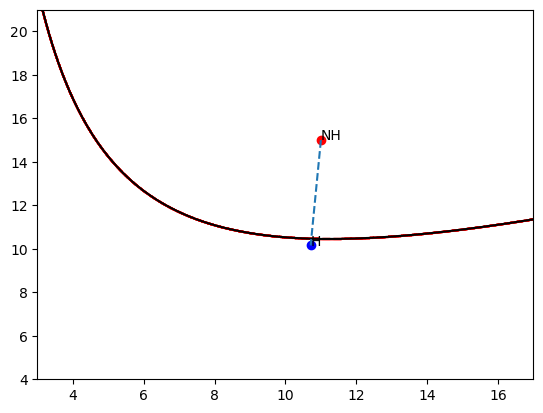

In [24]:
optimal_projection1 = optimal_point(df, svm_classifier, desired_class=1, undesired_coords=(11,15), epsilon=0.07)
optimal_projection1

     x1  x2
0   7.0  20
1   8.0  12
2   9.0  19
3  10.0  17
4  11.0  15
5  13.0  14
6  14.0  12
7  15.0  14
8  15.0  17
9  16.0  16
[1.05 1.05]
[-3.57287667 -0.64081566]
[1.05 1.05]
[-0.41273137 -0.69483239]
[1.05 1.05]
[-5.2099679  -1.29388044]
[1.05 1.05]
[-5.2122044  -2.30541949]
[1.05 1.05]
[-0.27051579 -4.52735538]
[1.05 1.05]
[ 0.51422413 -3.36581805]
[1.05 1.05]
[ 0.21451165 -1.25527237]
[1.05 1.05]
[ 0.72696416 -2.94918645]
[1.05 1.05]
[ 1.47632974 -5.77058424]
[1.05 1.05]
[ 0.98074854 -4.64298666]


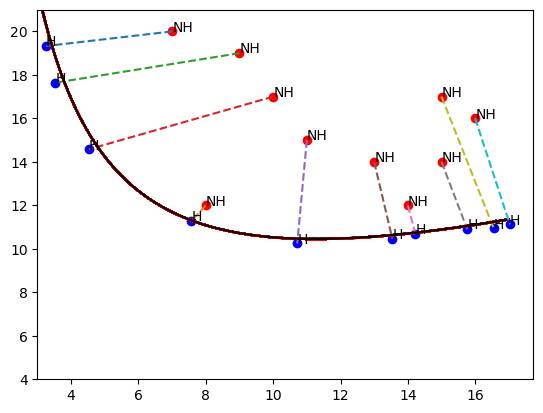

In [42]:
# Data frame consisting of all "non-healthy" data points or points where the classification is -1
undesired_df = df.loc[df['y'] == -1]

undesired_df = undesired_df.drop(columns=['y'])
print(undesired_df)
optimal_datapts1 = pd.DataFrame(data=[], columns=('x1', 'x2'))

# Iterates over each of the rows of the undesired dataframe and finds the optimal point
for r in range(undesired_df.shape[0]): 
    
    # Undesired data point
    data_pt = undesired_df.iloc[r]  
    optimal_pt = optimal_point(df, svm_classifier, desired_class=1, undesired_coords=(data_pt.iloc[0], data_pt.iloc[1]), epsilon=0.05)
    optimal_datapts1.loc[len(optimal_datapts1)] = optimal_pt

In [43]:
optimal_datapts1

,x1,x2
0,3.248479,19.327144
1,7.566632,11.270426
2,3.529534,17.641426
3,4.527185,14.579310
4,10.715958,10.246277
5,13.539935,10.465891
6,14.225237,10.681964
7,15.763312,10.903354
8,16.550146,10.940887
9,17.029786,11.124864


- The black line was generated from a set of points where the probability from the classifier matched 0.5 exactly or was sufficiently close to 0.5 (50%) 
- The red line was generated using the boundary function that we have defined above

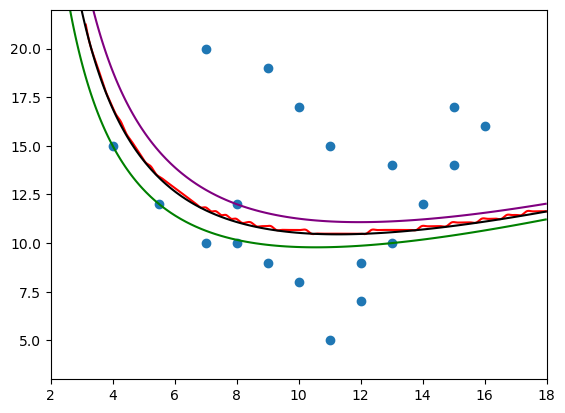

In [44]:
X1=df['x1']
X2=df['x2']
X_train=np.array(list(zip(X1,X2)))
y_train=df['y'].values
X=X_train

svm_classifier.fit(X_train, y_train)

X = X_train
x1_min, x1_max = X[:, 0].min() - 2, X[:, 0].max() + 2
x2_min, x2_max = X[:, 1].min() - 2, X[:, 1].max() + 2

xx1, xx2 = np.meshgrid(np.linspace(x1_min,x1_max, 100),np.linspace(x2_min, x2_max, 100))
Z = svm_classifier.decision_function(np.array([xx1.ravel(), xx2.ravel()]).T).reshape(xx1.shape)
x_in = np.c_[xx1.ravel(), xx2.ravel()]
y_pred = svm_classifier.predict(x_in)
y_pred = np.round(y_pred).reshape(xx1.shape)

bound_data = []
contour = plt.contour(xx1, xx2, y_pred, colors='black')
for collection in contour.collections[:1]:
    for path in collection.get_paths():
        vertices = path.vertices
        x_coords = vertices[:, 0]
        y_coords = vertices[:, 1]
        bound_data.extend(zip(x_coords,y_coords))
for collection in contour.collections:
    collection.set_visible(False)
boundary_df = pd.DataFrame(data=bound_data, columns=['x1','x2'])
N=200000
boundary_df = boundary_df.drop_duplicates(subset='x1')
bound_x, bound_y = boundary_df.iloc[:, 0], boundary_df.iloc[:, 1]

f = interp1d(bound_x, bound_y, kind='cubic')
X_pred = np.linspace(np.min(bound_x), np.max(bound_x), N)[:, np.newaxis]
Y_pred = f(X_pred)
plt.plot(X_pred, Y_pred, c='r')
plt.contour(xx1, xx2, Z, levels=[-1, 0, 1], colors=['purple','black','green'])
plt.scatter(X[:, 0], X[:, 1])
plt.show()

# Applying Constraints on both $X_1$ and $X_2$ 

- Below, we apply the constraints to the magnitude of the direction vector from the original unhealthy point to the decision boundary 
- We apply the constraints independently for each feature $x_1$ and $x_2$ while fixing the other constraint. For instance, we fix $x_2$ feature while changing the scale factor for the direction of the $x_1$ feature. We also do this vice versa for the other feature.

Parameters: 
- Apply $\epsilon = 0.05$ and undesired coordinates $(11,15)$ 

First, we evaluate the ```optimal_point()``` function for the above parameters and get the optimal coordinates $(3.529, 17.641)$

[1.07 1.07]
[-0.27051579 -4.52735538]


array([10.71054811, 10.15572974])

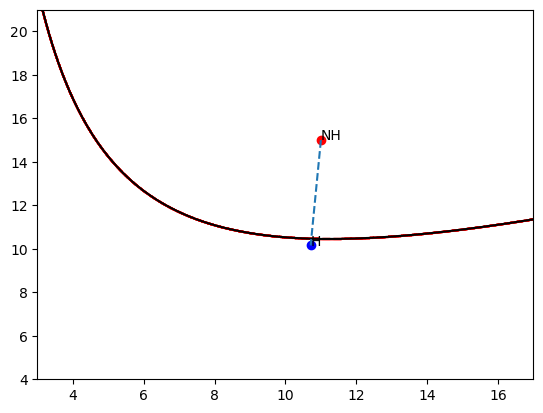

In [45]:
optimal_projection = optimal_point(df, svm_classifier, desired_class=1, undesired_coords=(11,15), epsilon=0.07)
optimal_projection

We now fix the $x_2$ feature using the $x_2$ constraint variable and then change the $x_1$ feature across different scales, 5%, 10%, 15%, 20%, 25%.

[1. 1.]
[-0.55 -0.75]


array([10.45, 14.25])

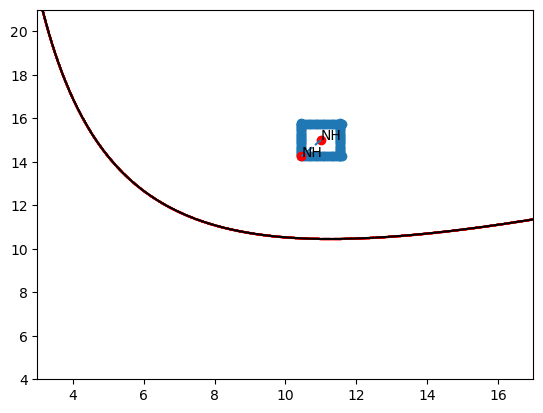

In [10]:
optimal_projection = optimal_point(df, svm_classifier, desired_class=-1, undesired_coords=(11,15), change_px=5, change_py=5)
optimal_projection

[1. 1.]
[-1.1  -0.75]


array([ 9.9 , 14.25])

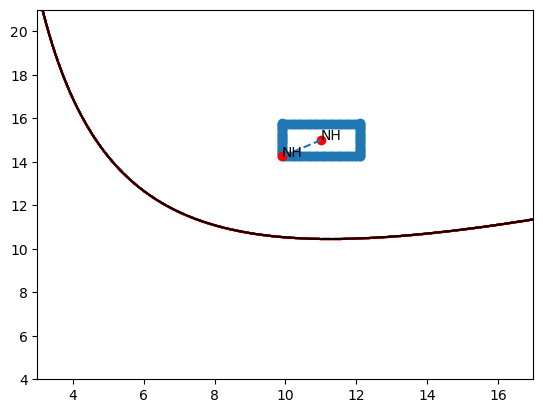

In [11]:
optimal_projection = optimal_point(df, svm_classifier, desired_class=-1, undesired_coords=(11,15), change_px=10, change_py=5)
optimal_projection

[1. 1.]
[-1.65 -0.75]


array([ 9.35, 14.25])

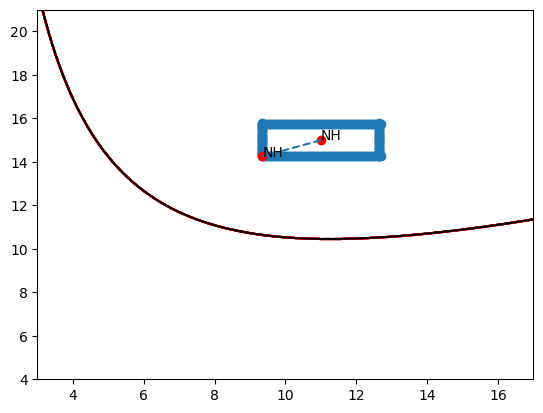

In [12]:
optimal_projection = optimal_point(df, svm_classifier, desired_class=-1, undesired_coords=(11,15), change_px=15, change_py=5)
optimal_projection

[1. 1.]
[-2.2  -0.75]


array([ 8.8 , 14.25])

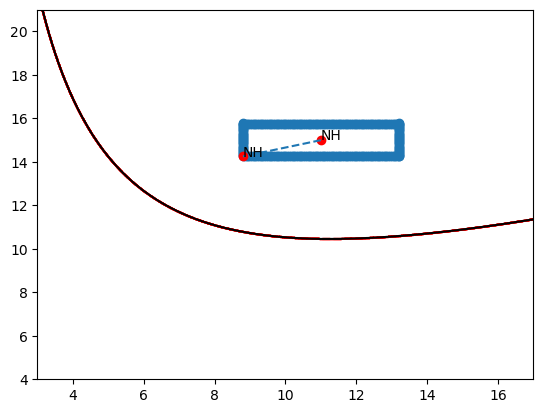

In [13]:
optimal_projection = optimal_point(df, svm_classifier, desired_class=-1, undesired_coords=(11,15), change_px=20, change_py=5)
optimal_projection

[1. 1.]
[-2.75 -0.75]


array([ 8.25, 14.25])

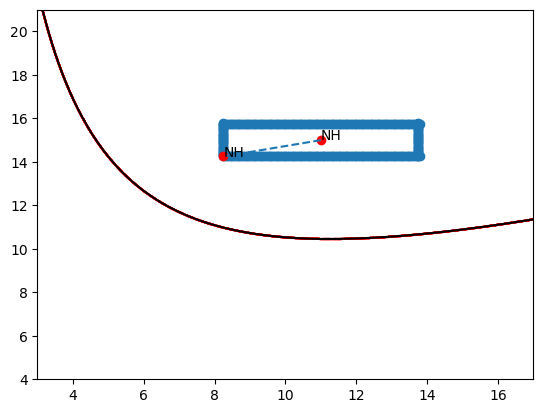

In [14]:
optimal_projection = optimal_point(df, svm_classifier, desired_class=-1, undesired_coords=(11,15), change_px=25, change_py=5)
optimal_projection

We now fix the $x_1$ feature using the $x_1$ constraint variable and then change the $x_2$ feature across different scales, 5%, 10%, 15%, 20%, 25%.

[1. 1.]
[-0.55 -0.75]


array([10.45, 14.25])

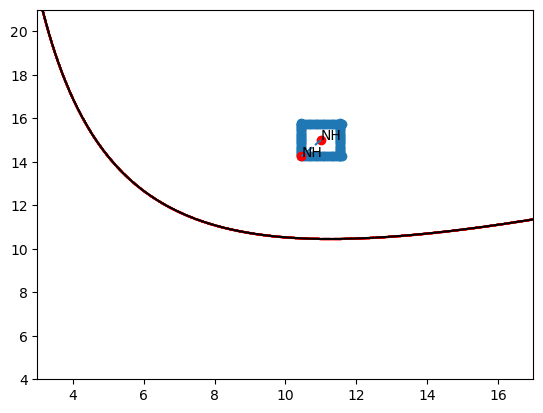

In [15]:
optimal_projection = optimal_point(df, svm_classifier, desired_class=-1, undesired_coords=(11,15), change_px=5, change_py=5)
optimal_projection

[1. 1.]
[-0.55 -1.5 ]


array([10.45, 13.5 ])

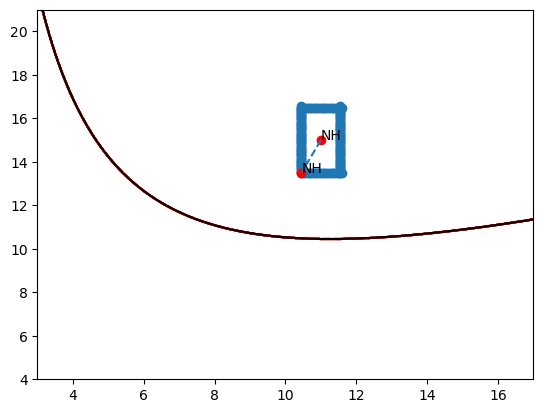

In [16]:
optimal_projection = optimal_point(df, svm_classifier, desired_class=-1, undesired_coords=(11,15), change_px=5, change_py=10)
optimal_projection

[1. 1.]
[-0.55 -2.25]


array([10.45, 12.75])

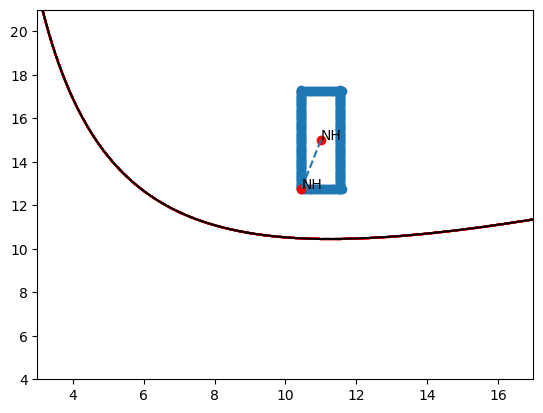

In [17]:
optimal_projection = optimal_point(df, svm_classifier, desired_class=-1, undesired_coords=(11,15), change_px=5, change_py=15)
optimal_projection

[1. 1.]
[-0.55 -3.  ]


array([10.45, 12.  ])

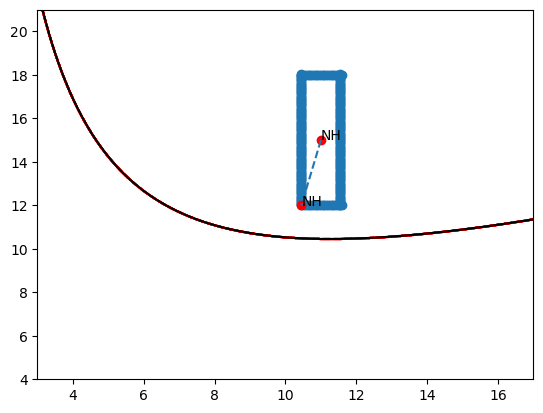

In [18]:
optimal_projection = optimal_point(df, svm_classifier, desired_class=-1, undesired_coords=(11,15), change_px=5, change_py=20)
optimal_projection

[1. 1.]
[-0.55 -3.75]


array([10.45, 11.25])

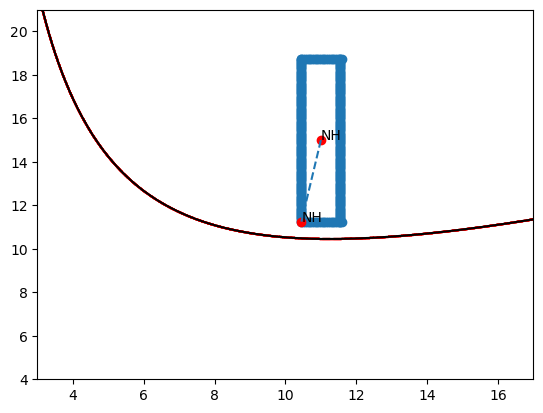

In [19]:
optimal_projection = optimal_point(df, svm_classifier, desired_class=-1, undesired_coords=(11,15), change_px=5, change_py=25)
optimal_projection

[1. 1.]
[-0.55 -0.75]


array([10.45, 14.25])

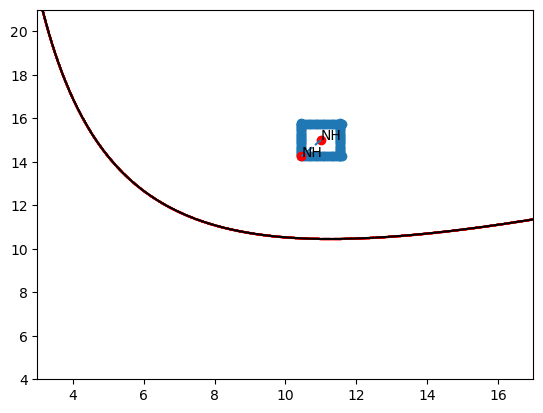

In [20]:
optimal_projection = optimal_point(df, svm_classifier, desired_class=-1, undesired_coords=(11,15), change_px=5, change_py=5)
optimal_projection

[1. 1.]
[-1.1 -1.5]


array([ 9.9, 13.5])

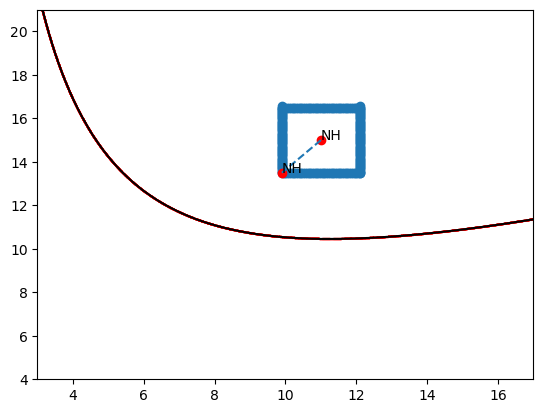

In [21]:
optimal_projection = optimal_point(df, svm_classifier, desired_class=-1, undesired_coords=(11,15), change_px=10, change_py=10)
optimal_projection

[1. 1.]
[-1.65 -2.25]


array([ 9.35, 12.75])

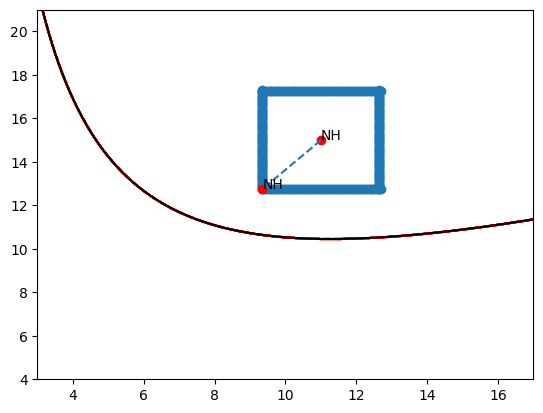

In [22]:
optimal_projection = optimal_point(df, svm_classifier, desired_class=-1, undesired_coords=(11,15), change_px=15, change_py=15)
optimal_projection

[1. 1.]
[-2.2 -3. ]


array([ 8.8, 12. ])

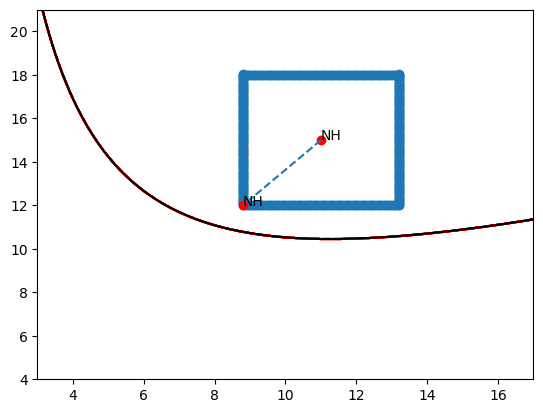

In [23]:
optimal_projection = optimal_point(df, svm_classifier, desired_class=-1, undesired_coords=(11,15), change_px=20, change_py=20)
optimal_projection

[1. 1.]
[ 3.3  -4.25]


array([14.3 , 10.75])

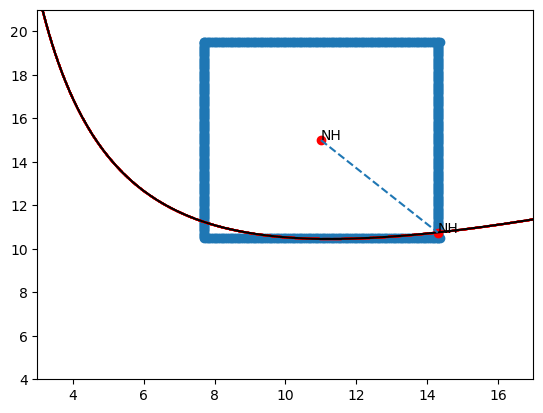

In [24]:
optimal_projection = optimal_point(df, svm_classifier, desired_class=-1, undesired_coords=(11,15), change_px=30, change_py=30)
optimal_projection

TypeError: change_px and change_py are both None

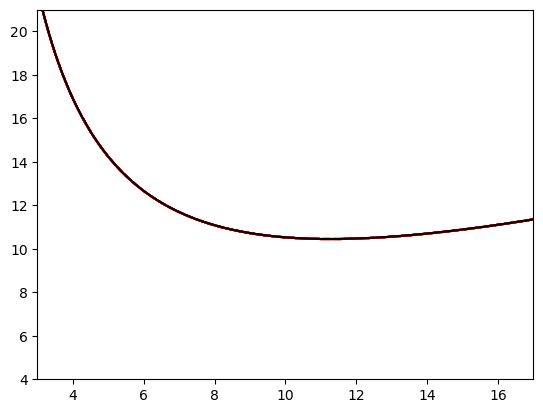

In [25]:
optimal_projection = optimal_point(df, svm_classifier, desired_class=-1, undesired_coords=(11,15), change_px='inf', change_py='inf')

TypeError: change_px and change_py are both None

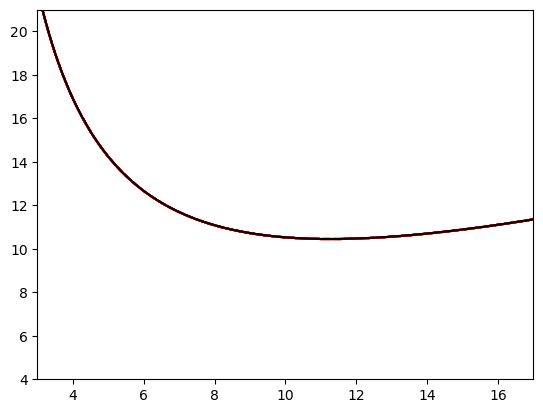

In [26]:
optimal_projection = optimal_point(df, svm_classifier, desired_class=-1, undesired_coords=(11,15))

UPPER AND LOWER BOUNDS ON X:  10.8625 11.1375
CLOSEST BOUNDING POINT:  [10.96036316 10.46414829]
[1. 1.]
[-0.03963684 -4.53585171]


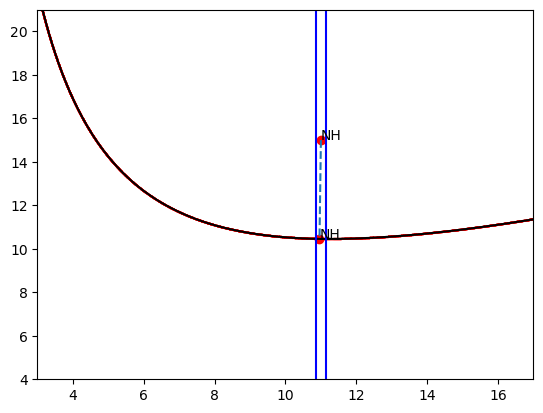

In [7]:
optimal_projection = optimal_point(df, svm_classifier, desired_class=-1, undesired_coords=(11,15), change_px=2.5, change_py=None)

UPPER AND LOWER BOUNDS ON X:  10.725 11.275
CLOSEST BOUNDING POINT:  [10.72948421 10.47264462]
[1. 1.]
[-0.27051579 -4.52735538]


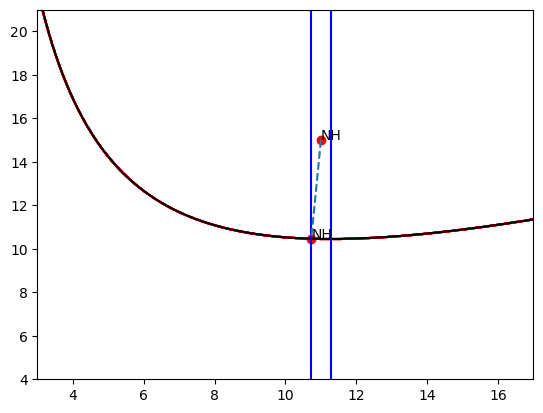

In [8]:
optimal_projection = optimal_point(df, svm_classifier, desired_class=-1, undesired_coords=(11,15), change_px=5, change_py=None)

UPPER AND LOWER BOUNDS ON X:  10.175 11.825
CLOSEST BOUNDING POINT:  [10.72948421 10.47264462]
[1. 1.]
[-0.27051579 -4.52735538]


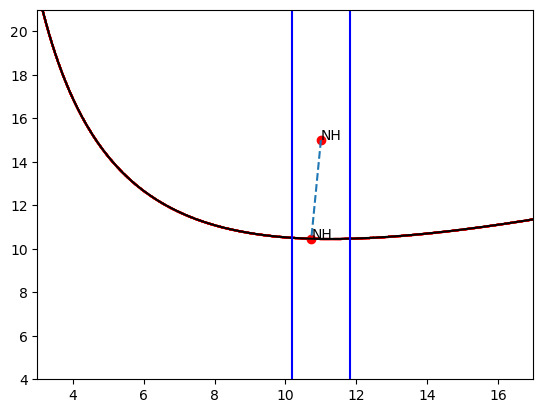

In [9]:
optimal_projection = optimal_point(df, svm_classifier, desired_class=-1, undesired_coords=(11,15), change_px=15, change_py=None)

UPPER AND LOWER BOUNDS ON X:  9.9 12.1
CLOSEST BOUNDING POINT:  [10.72948421 10.47264462]
[1. 1.]
[-0.27051579 -4.52735538]


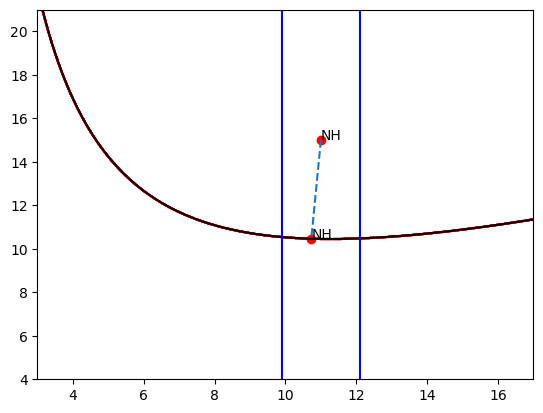

In [10]:
optimal_projection = optimal_point(df, svm_classifier, desired_class=-1, undesired_coords=(11,15), change_px=20, change_py=None)

UPPER AND LOWER BOUNDS ON X:  9.625 12.375
CLOSEST BOUNDING POINT:  [10.72948421 10.47264462]
[1. 1.]
[-0.27051579 -4.52735538]


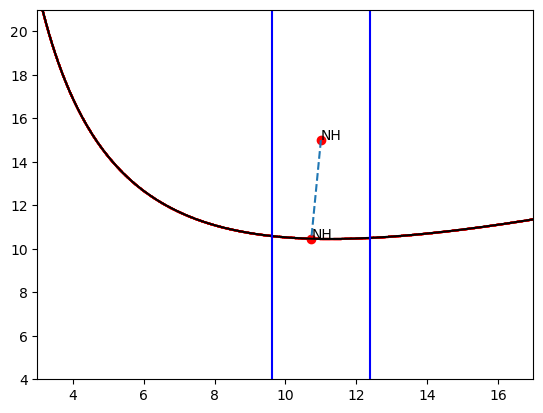

In [11]:
optimal_projection = optimal_point(df, svm_classifier, desired_class=-1, undesired_coords=(11,15), change_px=25, change_py='inf')

0.75
UPPER AND LOWER BOUNDS ON Y:  14.625 15.375
CLOSEST BOUNDING POINT:  [ 4.81587584 14.62502255]
[1. 1.]
[-6.18412416 -0.37497745]


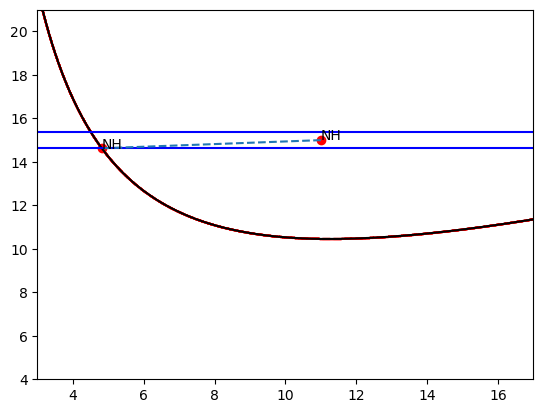

In [12]:
optimal_projection = optimal_point(df, svm_classifier, desired_class=-1, undesired_coords=(11,15), change_px='inf', change_py=5)

1.5
UPPER AND LOWER BOUNDS ON Y:  14.25 15.75
CLOSEST BOUNDING POINT:  [ 4.99515422 14.25002195]
[1. 1.]
[-6.00484578 -0.74997805]


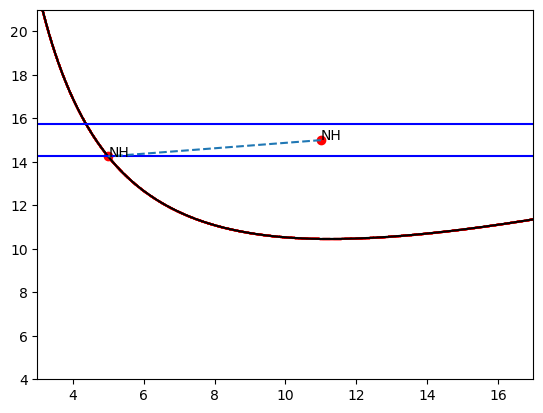

In [13]:
optimal_projection = optimal_point(df, svm_classifier, desired_class=-1, undesired_coords=(11,15), change_px='inf', change_py=10)

2.25
UPPER AND LOWER BOUNDS ON Y:  13.875 16.125
CLOSEST BOUNDING POINT:  [ 5.191314   13.87500838]
[1. 1.]
[-5.808686   -1.12499162]


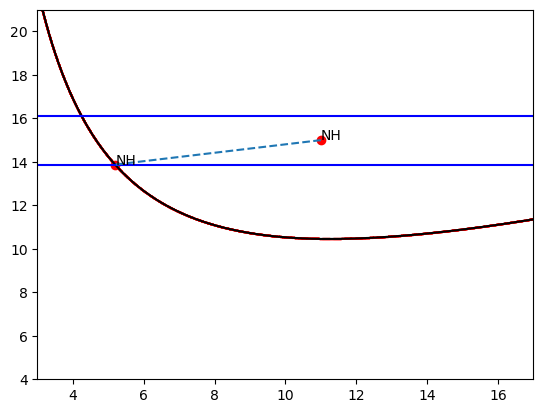

In [14]:
optimal_projection = optimal_point(df, svm_classifier, desired_class=-1, undesired_coords=(11,15), change_px=None, change_py=15)

3.75
UPPER AND LOWER BOUNDS ON Y:  13.125 16.875
CLOSEST BOUNDING POINT:  [ 5.65436086 13.12501789]
[1. 1.]
[-5.34563914 -1.87498211]


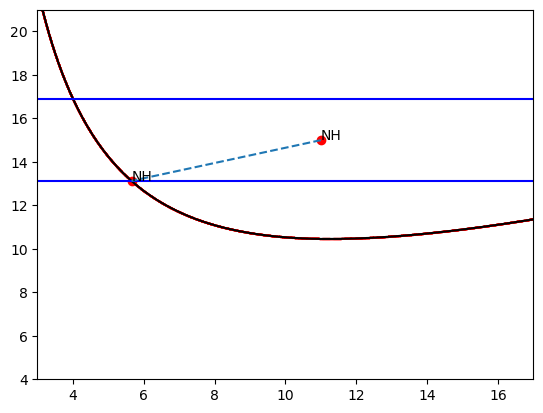

In [15]:
optimal_projection = optimal_point(df, svm_classifier, desired_class=-1, undesired_coords=(11,15), change_px=None, change_py=25)

5.25
UPPER AND LOWER BOUNDS ON Y:  12.375 17.625
CLOSEST BOUNDING POINT:  [ 6.25098987 12.3750061 ]
[1. 1.]
[-4.74901013 -2.6249939 ]


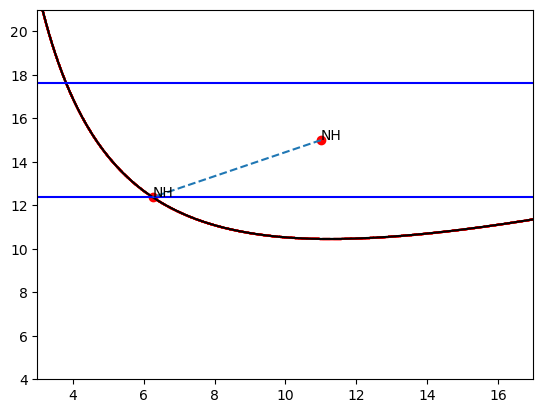

In [16]:
optimal_projection = optimal_point(df, svm_classifier, desired_class=-1, undesired_coords=(11,15), change_px=None, change_py=35)

# Synthetic Dataset Construction 

- Below, we construct a synthetic dataset consisting of three features. We have two features ```x1``` and ```x2``` and add a third feature to the SVM dataset for the sex of the patient.

In [2]:
import random 
import pandas as pd
random.seed(0)
synthetic_df = pd.read_csv('processed.cleveland.data')
synthetic_df.columns = ['age', 'sex', 'cp', 'trestbps', 'chol', 
                        'fbs', 'restecg', 'thalach', 'exang',
                         'oldpeak', 'slope', 'ca', 'thal', 'num']
synthetic_df

c:\Users\Compuworld\anaconda3\Lib\site-packages\pandas\core\arrays\masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,num
0,67.0,1.0,4.0,160.0,286.0,0.0,2.0,108.0,1.0,1.5,2.0,3.0,3.0,2
1,67.0,1.0,4.0,120.0,229.0,0.0,2.0,129.0,1.0,2.6,2.0,2.0,7.0,1
2,37.0,1.0,3.0,130.0,250.0,0.0,0.0,187.0,0.0,3.5,3.0,0.0,3.0,0
3,41.0,0.0,2.0,130.0,204.0,0.0,2.0,172.0,0.0,1.4,1.0,0.0,3.0,0
4,56.0,1.0,2.0,120.0,236.0,0.0,0.0,178.0,0.0,0.8,1.0,0.0,3.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
297,45.0,1.0,1.0,110.0,264.0,0.0,0.0,132.0,0.0,1.2,2.0,0.0,7.0,1
298,68.0,1.0,4.0,144.0,193.0,1.0,0.0,141.0,0.0,3.4,2.0,2.0,7.0,2
299,57.0,1.0,4.0,130.0,131.0,0.0,0.0,115.0,1.0,1.2,2.0,1.0,7.0,3
300,57.0,0.0,2.0,130.0,236.0,0.0,2.0,174.0,0.0,0.0,2.0,1.0,3.0,1


# Removing Categorical Features 

- We remove all categorical features except for only categorical feature, namely the "sex" of the patient

In [3]:
cat_features_removed = ['cp', 'fbs', 'restecg', 'exang', 'slope', 'thal', 'ca']

synthetic_df = synthetic_df.drop(cat_features_removed, axis=1)
synthetic_df

,age,sex,trestbps,chol,thalach,oldpeak,num
0,67.0,1.0,160.0,286.0,108.0,1.5,2
1,67.0,1.0,120.0,229.0,129.0,2.6,1
2,37.0,1.0,130.0,250.0,187.0,3.5,0
3,41.0,0.0,130.0,204.0,172.0,1.4,0
4,56.0,1.0,120.0,236.0,178.0,0.8,0
...,...,...,...,...,...,...,...
297,45.0,1.0,110.0,264.0,132.0,1.2,1
298,68.0,1.0,144.0,193.0,141.0,3.4,2
299,57.0,1.0,130.0,131.0,115.0,1.2,3
300,57.0,0.0,130.0,236.0,174.0,0.0,1


In [4]:
synthetic_df.loc[synthetic_df['num'] > 0, 'num'] = 1

In [5]:
synthetic_df

,age,sex,trestbps,chol,thalach,oldpeak,num
0,67.0,1.0,160.0,286.0,108.0,1.5,1
1,67.0,1.0,120.0,229.0,129.0,2.6,1
2,37.0,1.0,130.0,250.0,187.0,3.5,0
3,41.0,0.0,130.0,204.0,172.0,1.4,0
4,56.0,1.0,120.0,236.0,178.0,0.8,0
...,...,...,...,...,...,...,...
297,45.0,1.0,110.0,264.0,132.0,1.2,1
298,68.0,1.0,144.0,193.0,141.0,3.4,1
299,57.0,1.0,130.0,131.0,115.0,1.2,1
300,57.0,0.0,130.0,236.0,174.0,0.0,1


In [6]:
from sklearn.model_selection import train_test_split 

X = synthetic_df.drop(columns='num')
y = synthetic_df['num']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42) 

print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(241, 6) (61, 6) (241,) (61,)


In [7]:
X_train

,age,sex,trestbps,chol,thalach,oldpeak
132,51.0,1.0,140.0,261.0,186.0,0.0
202,64.0,0.0,140.0,313.0,133.0,0.2
196,45.0,0.0,138.0,236.0,152.0,0.2
75,60.0,1.0,125.0,258.0,141.0,2.8
176,56.0,1.0,132.0,184.0,105.0,2.1
...,...,...,...,...,...,...
188,69.0,1.0,140.0,254.0,146.0,2.0
71,62.0,1.0,120.0,267.0,99.0,1.8
106,57.0,1.0,128.0,229.0,150.0,0.4
270,66.0,1.0,160.0,228.0,138.0,2.3


In [8]:
duplicates = X_train.duplicated()
duplicates.any()

False

In [9]:
y_train

132    0
202    0
196    0
75     1
176    1
      ..
188    1
71     1
106    1
270    0
102    0
Name: num, Length: 241, dtype: int64

# Working with Categorical Features

- We want to generalize the decision boundary function for any $N$ number of features including $C$ categorical features. 
- We want to ensure that the search space is only $N-C$ whereas the model fits on the entire $N$ set of features. 

# Using the Synthetic Dataset 

- Below, we use the synthetic dataset constructed from three features (two from the original SVM dataset and one categorical variable for the sex of the patient) 
- As shown below, we return the optimal data point where we exclude the categorical feature "sex"

In [36]:
print(X_train.shape, y_train.shape)

(20, 2) (20,)


In [37]:
svm_classifier.fit(X_train, y_train)

SVC(C=10, degree=2, kernel='poly', probability=True)

# Decision Boundary Points # 

If you want to extract the decision boundary points (not the plot) for a trained machine learning model with multiple features (e.g., 4 features), you can compute the decision boundary by evaluating the model's predictions on a grid of points in the feature space. The decision boundary is where the model's predicted class changes.
Here’s how you can compute the decision boundary points for a model with 4 features:
 

In [46]:
from sklearn.datasets import make_classification
from sklearn.linear_model import LogisticRegression

# Computing the Decision Boundary Points 

- Problem is that the function computes the grid points using an exponential time-complexity algorithm $O(R^{2f})$ which is the exponential in the number of additional features $f$

In [ ]:
import numpy as np 
X, y = make_classification(n_samples=1000, n_features=4, n_informative=4, n_redundant=0, random_state=42)
 
# Train a Logistic Regression model (or any other classifier)
model = LogisticRegression()
model.fit(X, y)

def compute_decision_boundary_points_cpu(model, X, resolution=100, epsilon=0.01):
    """
    Compute decision boundary points in the high-dimensional feature space.
    Args:
        model: Trained classifier.
        X: Input data (n_samples, n_features).
        resolution: Number of points to sample along each feature axis.
        epsilon: Small step size to detect class changes.
    Returns:
        boundary_points: Array of points near the decision boundary.
    """
    n_features = X.shape[1]
    boundary_points = []
    
    # Create a grid for all features
    # Generating such a large grid size and then performing a double for loop is a slow operation
    grid = np.zeros((resolution ** n_features, n_features))
    for i, feature in enumerate(range(n_features)):
        np_array = np.linspace(X[:, feature].min() - 1, X[:, feature].max() + 1, resolution ** (n_features)).reshape(-1)
        grid[:, i] = np_array 

    # Predict the class for each point in the grid
    Z = model.predict(grid)
 
    # Find points near the decision boundary
    for i in range(len(grid) - 1):
        for j in range(i + 1, len(grid)):
            if np.linalg.norm(grid[i] - grid[j]) < epsilon and Z[i] != Z[j]:
                boundary_points.append((grid[i] + grid[j]) / 2)  # Midpoint between two classes
 
    return np.array(boundary_points)

In [31]:
# Compute decision boundary points considering all features
boundary_points = compute_decision_boundary_points_cpu(model, X, resolution=10, epsilon=0.1)
 
# Print the decision boundary points
print("Decision Boundary Points (All Features):")
print(boundary_points)
print(boundary_points.shape)

Decision Boundary Points (All Features):
[[-0.59505167 -0.34051837 -0.32668678  0.25282816]
 [-0.59452979 -0.34000234 -0.32612784  0.25341543]
 [-0.5940079  -0.33948632 -0.32556891  0.25400269]
 ...
 [-0.55016979 -0.29614016 -0.27861863  0.30333282]
 [-0.54964791 -0.29562414 -0.2780597   0.30392009]
 [-0.54912603 -0.29510811 -0.27750077  0.30450735]]
(1035, 4)


In [61]:
print("Decision Boundary Points (Probability Across Both classes):")
model.predict_proba(boundary_points) 

Decision Boundary Points (Probability Across Both classes):


array([[0.50653839, 0.49346161],
       [0.50646862, 0.49353138],
       [0.50639885, 0.49360115],
       ...,
       [0.49369896, 0.50630104],
       [0.49362919, 0.50637081],
       [0.49355942, 0.50644058]])

# Direct Approach (Linear Algebra based) 

- Predict on the model outputs and then apply broadcasting to the output probabilities
- Generating a meshgrid using the numpy is not high time-complexity and we run a $O(R^f)$ time complexity algorithm (Predicting from the points and then generating points)
- An area to explore

In [ ]:
n_features = X.shape[1]
ranges = [np.linspace(X[:, j].min() - 1, X[:, j].max() + 1, 35) for j in range(n_features)]
grids = np.meshgrid(*ranges) 

grid_points = np.vstack([g.ravel() for g in grids]).T
print(grid_points.shape)

In [ ]:
# Get probability predictions (ensure model outputs probabilities)
prob0 = model.predict_proba(grid_points)[:, 0] 

# Find points near the decision boundary (P(class 1) ≈ 0.5)
threshold = 0.01 # Tight threshold for "50%-50%" (adjust as needed)
boundary_mask = np.abs(prob0 - 0.5) < threshold
print(grid_points[boundary_mask].shape)
print(model.predict_proba(grid_points[boundary_mask]))

In [32]:
from scipy.interpolate import RBFInterpolator 
print(boundary_points.shape)
n_features = X.shape[1]
X_vals, y_vals = boundary_points[:,0:n_features-1], np.reshape(boundary_points[:,-1], (-1,1)) 
print(y_vals.shape)
interpolator = RBFInterpolator(X_vals, y_vals, kernel='cubic', smoothing=1e-12)

(1035, 4)
(1035, 1)


In [33]:
n_features = X.shape[1]
ranges = [np.linspace(boundary_points[:, j].min(), boundary_points[:, j].max(), 25) for j in range(n_features)]
grids = np.meshgrid(*ranges) 

grid_points = np.vstack([g.ravel() for g in grids]).T
print(grid_points.shape)

(390625, 4)


In [34]:
eval_coords = grid_points[:,0:n_features-1]
print(eval_coords.shape)
eval_values = interpolator(eval_coords)
add_boundary_pts = np.hstack((eval_coords, eval_values))
print(eval_coords.shape)
print(eval_values.shape)
print(add_boundary_pts.shape)

(390625, 3)
(390625, 3)
(390625, 1)
(390625, 4)


In [35]:
model.predict_proba(add_boundary_pts)

array([[0.50644943, 0.49355057],
       [0.50644943, 0.49355057],
       [0.50644943, 0.49355057],
       ...,
       [0.49371562, 0.50628438],
       [0.49371562, 0.50628438],
       [0.49371562, 0.50628438]])

# Constructing Final Function

- Uses the CPU version only (original version) 

In [64]:
from scipy.interpolate import interp1d
from scipy.interpolate import RBFInterpolator
import numba 
from numba import cuda


def multi_dim_interpolator(boundary_points): 
    n_features = boundary_points.shape[1]
    X_vals, y_vals = boundary_points[:,0:n_features-1], np.reshape(boundary_points[:,-1], (-1,1)) 
    interpolator = RBFInterpolator(X_vals, y_vals, kernel='cubic', smoothing=1e-12)
    return interpolator 

@numba.njit
def find_boundary_cpu(grid, Z, epsilon):
    boundary_points = []
    for i in range(len(grid) - 1):
        for j in range(i + 1, len(grid)):
            if np.linalg.norm(grid[i] - grid[j]) < epsilon and Z[i] != Z[j]:
                midpoint = (grid[i] + grid[j]) / 2
                boundary_points.append(midpoint)
    return boundary_points

@cuda.jit 
def find_boundary_gpu(grid, Z, epsilon, boundary_points, count):
    i = cuda.grid(1)
    n = grid.shape[0]

    if i < n:
        for j in range(i + 1, n):
            dist = 0.0
            for k in range(grid.shape[1]):
                diff = grid[i, k] - grid[j, k]
                dist += diff * diff
            dist = dist ** 0.5

            if dist < epsilon and Z[i] != Z[j]:
                idx = cuda.atomic.add(count, 0, 1)
                for d in range(grid.shape[1]):
                    boundary_points[idx, d] = (grid[i, d] + grid[j, d]) / 2

def compute_decision_boundary_points_cpu(model, X, resolution=100, precision=0.01):
    """
    Compute decision boundary points in the high-dimensional feature space.
    Args:
        model: Trained classifier.
        X: Input data (n_samples, n_features).
        resolution: Number of points to sample along each feature axis.
        precision: Small step size to detect class changes.
    Returns:
        boundary_points: Array of points near the decision boundary.
    """
    
    n_features = X.shape[1]
    grid_size = resolution ** n_features
    grid = np.zeros((grid_size, n_features))

    print(grid.shape) 
    
    for i in range(n_features):
        np_array = np.linspace(np.min(X[:, i],axis=0) - 1, np.max(X[:, i],axis=0) + 1, grid_size)
        print(np_array.shape)
        grid[:, i] = np_array

    Z = model.predict(grid)
    boundary_points = find_boundary_cpu(grid, Z, precision)

    return np.array(boundary_points)

def compute_decision_boundary_points_gpu(model, X, resolution=100, epsilon=0.01):
    """
    Compute decision boundary points in the high-dimensional feature space.
    Args:
        model: Trained classifier.
        X: Input data (n_samples, n_features).
        resolution: Number of points to sample along each feature axis.
        epsilon: Small step size to detect class changes.
    Returns:
        boundary_points: Array of points near the decision boundary.
    """
    n_features = X.shape[1]

    grid_size = resolution ** n_features
    grid = np.zeros((grid_size, n_features), dtype=np.float32)

    for i in range(n_features):
        grid[:, i] = np.linspace(X[:, i].min() - 1, X[:, i].max() + 1, grid_size)

    Z = model.predict(grid).astype(np.int32)

    d_grid = cuda.to_device(grid)
    d_Z = cuda.to_device(Z)
    max_boundary_points = grid_size  # worst case
    d_boundary_points = cuda.device_array((max_boundary_points, n_features), dtype=np.float32)
    d_count = cuda.to_device(np.array([0], dtype=np.int32))

    threads_per_block = 128
    blocks_per_grid = (grid_size + threads_per_block - 1) // threads_per_block

    find_boundary_gpu[blocks_per_grid, threads_per_block](d_grid, d_Z, epsilon, d_boundary_points, d_count)

    count = d_count.copy_to_host()[0]
    boundary_points = d_boundary_points.copy_to_host()[:count]

    return boundary_points

def generate_add_boundary_pts(boundary_points, N=25): 
    n_features = boundary_points.shape[1]
    ranges = [np.linspace(boundary_points[:, j].min(), boundary_points[:, j].max(), N) for j in range(n_features)]
    grids = np.meshgrid(*ranges) 
    grid_points = np.vstack([g.ravel() for g in grids]).T
    eval_coords = grid_points[:,0:n_features-1]
    return eval_coords 

# Generates the decision boundary in the case of binary classification
def boundary_generator(model, X, resolution=10, hw_type='cpu', precision=0.1):
    if hw_type == 'cpu':  
        boundary_points = compute_decision_boundary_points_cpu(model, X, resolution=resolution, precision=precision)
    else: 
        boundary_points = compute_decision_boundary_points_gpu(model, X, resolution=resolution, precision=precision) 
    return boundary_points

# Gets boundary points
def generate_boundary_points(model, X, resolution, hardware_type, precision): 
    boundary_arr = boundary_generator(model, X, resolution=resolution, hw_type=hardware_type, precision=precision)
    #boundary_arr = np.unique(boundary_arr, axis=0)
    return boundary_arr

def get_border_points(x, y, delta_x, delta_y, step=0.1):
    points = []        
    
    # Define the boundaries
    x_min, x_max = x - delta_x, x + delta_x
    y_min, y_max = y - delta_y, y + delta_y

    # Generate points along the four edges
    for i in np.arange(x_min, x_max + step, step):
        points.append((i, y_min))  # Bottom edge
        points.append((i, y_max))  # Top edge

    for j in np.arange(y_min, y_max + step, step):
        points.append((x_min, j))  # Left edge
        points.append((x_max, j))  # Right edge

    # Remove duplicates (corner points get added twice)
    points = list(set(points))
    
    return points

In [65]:

def det_constraint_vars(changes): 
    constraints = [-1] * len(changes) 

    for i, change in enumerate(changes): 
        if type(change) == float or type(change) == int:
            constraints[i] = change

    return constraints  

def constraint_bounds(contours, datapt, constraints): 
    bounded_contour = contours.copy() 
    
    for i, change_x in enumerate(constraints): 
        if constraints[i] > 0:
            x = datapt[i]
            delta_x = (change_x/100)*x
            # Generate a lower and upper bounds on each constraint
            lowb_x, highb_x = x - (delta_x / 2), x + (delta_x / 2)

            contour_arr = bounded_contour[:, i]

            # Choose the correct indices for the multi-dimensional df
            indices = np.where((contour_arr >= lowb_x) & (contour_arr <= highb_x))
            bounded_contour_pts = bounded_contour[indices]
            bounded_contour = bounded_contour_pts
    
    return bounded_contour

# Algorithm that determines the point that is closest to the decision boundary from a specified data point (undesired_coords) 
def optimal_point(dataset, model, desired_class, undesired_coords, hardware_type='cpu', resolution=15, precision=0.01, epsilon=0.01, changes=[]): 
    X_train, y_train = dataset[:, 0:dataset.shape[1]-1], dataset[:, -1]

    model.fit(X_train, y_train)

    # Generate points on multi-dimensional contour
    boundary_points = generate_boundary_points(model, X_train, resolution, hardware_type, precision)
    
    # # Interpolation function 
    # f = multi_dim_interpolator(boundary_points=boundary_points)

    # # Generate additional points for interpolation
    # eval_coords = generate_add_boundary_pts(boundary_points=boundary_points, N=100)
    # eval_values = f(eval_coords)
    # print(eval_coords.shape, eval_values.shape)
    # add_boundary_pts = np.hstack((eval_coords, eval_values))
    # print(add_boundary_pts.shape)

    # Generate final contour for multi-dimensional case
    # contours = np.vstack((boundary_points, add_boundary_pts))
    undesired_datapt = np.array(undesired_coords)
    print(boundary_points.shape)
    contours = np.c_[boundary_points[:,0], boundary_points[:,1]]
    plt.plot(boundary_points[:,0], boundary_points[:,1], color='black')
    # Find the closest point from the undesired point to the contour line
    optimal_datapt = closest_point(undesired_datapt, contour=boundary_points)

    if desired_class == 1: 
        D = optimal_datapt - undesired_datapt
        deltas = D * (1+epsilon)
        optimal_datapt = move_from_A_to_B_with_x1_displacement(undesired_datapt, optimal_datapt, deltas=deltas)
        return optimal_datapt 
    elif desired_class == -1: 
        deltas = [None] * X.shape[1]
        closest_boundedpt = None
        constraints = det_constraint_vars(changes)
        # Generate bounded contour points
        bounded_contour_pts = constraint_bounds(contours, undesired_datapt, constraints)
        closest_boundedpt = closest_point(point=undesired_datapt, contour=bounded_contour_pts)
        D = closest_boundedpt - undesired_datapt
        optimal_datapt = move_from_A_to_B_with_x1_displacement(undesired_datapt, closest_boundedpt, deltas=D)
        return optimal_datapt

(15625, 2)
(15625,)
(15625,)
(28, 2)
[1.07 1.07]
[-2.36962366 -4.16311444]


array([ 8.46450269, 10.54546755])

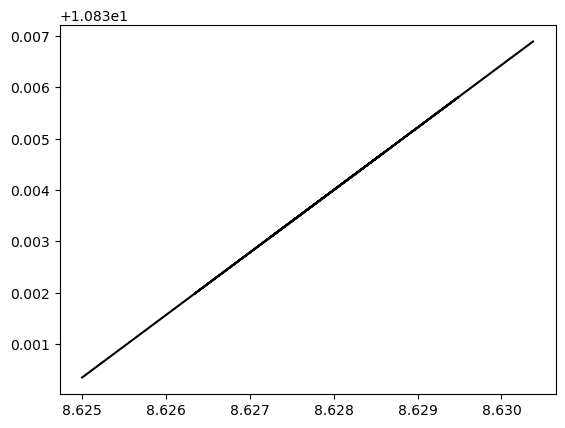

In [66]:
optimal_point(df.to_numpy(), svm_classifier, desired_class=1, resolution=125, undesired_coords=(11,15), precision=0.01, epsilon=0.07)

# array([10.71054811, 10.15572974])
